# Introduction to Deep Learning with Keras + TensorFlow

This notebook provides a very brief introduction to the theory behind deep neural networks. There are tons great resources online for digging deaper into the theory and maths behind deep learning, this introduction will be very high level and I'll gloss over some details. My goal with the conceptual intro is to give you just enough intuition to make sense of the code we'll look at later.

Following the theorical foundation, we'll dive straight into some examples in code to demonstrate how to build deep neural networks in TensorFlow using Keras. We'll look at a classic image classification task using the MNIST handwritten digit dataset. From there we'll move on to time series anomoly detection with a [Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) network.

## Deep Learning Basics

[Deep learning](https://en.wikipedia.org/wiki/Deep_learning) is a field of machine learning that uses artificial neural networks to perform learning tasks. These neural networks are called "deep" because they have many layers of neurons. 

<img src="images/AI-ML-DL.svg" alt="deep learning in context" width="400">

<a href="https://commons.wikimedia.org/wiki/File:AI-ML-DL.svg">Original file: Avimanyu786SVG version: Tukijaaliwa</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons

The theoritical beginnings of deep learning can be traced to the work of [Frank Rosenblatt](https://en.wikipedia.org/wiki/Frank_Rosenblatt) in the 1960s. However, advances in GPU technology such as [tensor cores](https://www.nvidia.com/en-us/data-center/tensor-cores/) among others, and the availability of big data have helped the field take off in recent years. GPUs are particularly important as they enable massive parallelism for the kinds of linear algebra and matrix and calculus operations used when training models.

### The Artificial Neuron

Essentially, a neural network is a function approximator. We'd like the network to learn a function `f(x)` that maps some input X to some prediction Y. For example, given an image of a cat, we'd like the network to learn a function that takes as inputs the pixels of an image and correctly "predicts" that the image as a cat.

Deep neural networks are composed of layers of inter-connected neurons. Each neuron perfoms a simple linear transformation on its inputs, and passes result of that transformation through a non-linear "activation function." The non-linearity is important because it allows the network to learn complex non-linear functions. Without the non-linear activation function, the network would only be able to learn linear functions.

![single neuron](images/neuron.jpg)

`f(x) = wx + b` 

(this is our old friend `y = mx + b` from back in the day except that *w and x are vectors*)

`Neuron output = activation_function(f(x))`

AI researchers have explored different activation fuctions, and this is still an area of active research. One commmon activation function is the [Recified Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) or ReLU. This simple function returns zero when its input is negative, and returns the same value for positve inputs. In Python this is just `max(0, x)`. We'll use ReLU in our experiments today.

### Training Deep Neural Networks

![neural network](images/network.jpg)

At a high level, the process to train a neural network is as follows:
1. Initialize the weights and biases to small, normally distributed positive numbers.
1. Make a prediction on a small (mini) batch of the training data. Typically NNs are trained on huge datasets so it's necessary to break the training data into "mini-batches." TensorFlow will do this for us automatically.
1. Use a loss function to calculate the "badness" of the prediction. There are different loss functions for different learning tasks. Since the network starts with random weights and biases, the initial predictions will be pretty bad.
1. Calculate the gradient (partial derivative) of the loss function at each of the outputs. This is a measure of how much the loss will change for a change in each output of the network.
1. Apply [back propagation](https://en.wikipedia.org/wiki/Backpropagation) to calculate the gradient of the loss with respect to each weight in the network. Again, this is a partial derivative that tells us how a small chage in each weight will change the loss.
1. Adjust all of the weights and biases by a small amount ("learning rate") in the direction of the gradient. In pseudo code this can be expressed by `weights -= learning_rate * gradients` and `biases -= learning_rate * gradients`.
1. Repeat the process on each batch of training data, adjusting the weights each time, until the model has seen all of the batches. One pass through all of the batches of the training data is called an epoch, and typically we'll need to train for several epochs.

This process of taking small steps in the direction that minimizes the loss by adjusting the model weights and biases by the learning rate times the gradient is called [gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). 

While it's fun to understand the theory because you can impress your friends at cocktail parties, in practice, modern deep learning frameworks like TensorFlow and PyTorch take care of nearly all of this for us.

Let's jump in.

## The "Hello World" of Deep Learning
The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digit classification task is sort of the hello world of deep learning. The [original paper](https://en.wikipedia.org/wiki/MNIST_database) by LeCun et al is a classic worth reading.

LeCun's work on MNIST in 1998 built on postal code recognition work from a decade earlier and was revolutionary at the time. Today, we can replicate the results in TensorFlow with just a few lines of Python. First, we'll train a fully connected deep neural network (DNN) on MNIST. Then we'll train a convolutional neural network (CNN) to compare the difference in performance.

[Keras](https://keras.io/) is a Python API for deep learning that runs on top of TensorFlow. Check out the [Introduction to Keras for Engineers](https://keras.io/getting_started/intro_to_keras_for_engineers/) to learn more. Keras includes many machine learning benchmark [datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets), including MNIST. 

### Getting The MNIST Data

First, we import the mnist module and use it to download training and validation datasets. In machine learning, it's important to have a separate dataset that the model has never seen to test model performance. We need to know whether the model has discovered real patterns in the data that allow it generalize to data it has never seen, or if it's simply memorized the training data ([overritting](https://en.wikipedia.org/wiki/Overfitting#Machine_learning)). By convention, our training examples are typically called X, while our labels are called Y. 

This [article](https://machinelearningmastery.com/difference-test-validation-datasets/) by Jason Brownleee goes into more detail on training, validation and test datasets.

In [1]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

The MNIST data consists of 70,000 grayscale images of handwritten digits, 60,000 training images and 10,000 validation images. The images are small, only 28x28 pixels:

In [2]:
print(x_train.shape, x_valid.shape)

(60000, 28, 28) (10000, 28, 28)


Similarly, we can see there are 60,000 labels for the training data and 10,000 for the validation data:

In [3]:
print(y_train.shape, y_valid.shape)

(60000,) (10000,)


Let's look at the first image:

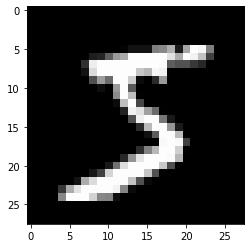

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0], cmap='gray')

Our labels indicate this is a 5:

In [5]:
y_train[0]

5

In [6]:
# TODO: play with the training data. Check out the dtype, min and max values to understand what we're working with.



### Data Preparation

Before we can train a network with this data, we need to perform some pre-processing steps. First, we'll scale the pixel values to be between 0 and 1. If you tried the `max()` and `min()` functions on the image array in the cell above, you saw that the pixel values range from 0 to 255. So we'll simply divide each pixel by 255 to scale the data.

In [7]:
x_train = x_train / 255
x_valid = x_valid / 255

For this simple example, we're not going to deal with the images as structures. We'll just flatten each 28x28 images into a single vector of lenth 784 to demonstrate a fully connected, or dense, neural network. This isn't the best approach for dealing with images, but it works for this example. Later, we'll see a more sophisticated technique that use convolutional layers to extract features from the image.

In [8]:
x_train = x_train.reshape(60000, 784)
x_valid = x_valid.reshape(10000, 784)

Now we need to deal with our labels. In the example above, we saw that the first label was a "5". Let's look at a few more:

In [9]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

### One Hot Encoding

These numerical labels won't work for training our network. Recall that in the training process, the model starts with random weights and biases, and just makes a guess. The intial guesses are pretty bad, and we use a mathematical function called a loss function to measure badness. Then we iteratively tune the weights and biases until we (hopefully) achieve acceptable performance. 

Consider the scenario where we show the model a 2 and it guesses 9. That's clearly incorrect, but what if the model guessed 1? That's closer. Is it a better guess? Not in this case, it's an equally bad guess. But if we use the numbers 0-9 for our training labels, and feed these into our loss function to measure badness, the model might learn that 1 is a better guess, since it's closer to the correct number. To avoid this, we'll do something called [one-hot encoding](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics), or categorical encoding.

Again, Keras makes this easy:

In [10]:
import tensorflow.keras as keras
n_categories = 10

y_train = keras.utils.to_categorical(y_train, n_categories)
y_valid = keras.utils.to_categorical(y_valid, n_categories)

In [11]:
y_train.shape

(60000, 10)

In [12]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

After categorical encoding, we see that our first training label has changed from a `5` to an array of lenth `10`. Note that the element at index `5` is `1` and all other elements are `0`.

In [13]:
import numpy as np
np.argmax(y_train[0])

5

### Training the Model
Now we're ready to build and train our model. Keras has a nice functional API that allows you build up a model, one layer at a time. The output of one layer is the input to the next.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#### Input Layer

First, we add the input layer. This layer must match the shape of our input. Since we flattened our 28x28 images into lenth 768 vectors, we need to tell Keras that the input layer has 784 inputs. We don't have to specify the number of inputs for subsequent layers as Keras will figure it out from the output of the previous layer. Here we add a dense, or fully connected, layer with 32 neurons and use the ReLU activation function.

Fully connected means that every neuron in each layer is connected to every neuron in the next, like the image above.

In [51]:
model = Sequential()
model.add(Dense(units=32, activation='relu', input_shape=(784,)))

#### Hidden Layers

Now we add the "hidden" layers. Hidden refers to the layers that are neither the input or the output of the network. We can have ad many of these as we want, in fact part of the work of applying deep learning to a domain problem is figuring out the most effective model architecture. How many hidden layers to use, how wide the layers should be, which activation function to use, etc. 

These parameters are called hyperparameters because we as modelers choose them. This is in contrast to the parameters (weights and biases) that are learned through the training process.

We'll add two hidden layers, also using the ReLU activation function.

In [52]:
model.add(Dense(units=16, activation='relu'))

#### Output Layer

Finally, we add the output layer. This is the layer that performs classification and gives us our predictions. The size of the output layer must match the number of classes in our data. Since MNIST contains the digits `0` through `9`, our output layer will have 10 units.

In the output layer, we use a different activation function. The `softmax` function turns the model's predictions into a probability distribution across the classes. In other words, the network will output a probability for each class: 2% probability of being a `0`, 70% probability f being a `1`, 8% probability of being a `2`, etc. We choose the class with the highest predicted probability as the output of the classification task.

In [53]:
model.add(Dense(units = 10, activation='softmax'))

#### Model Summary
Keras provides a `summary()` function that we can use to print all of the layers in the model, as well as the number of trainable parameters (weights and biases) that the model has. This is referred to as the model's capacity, as more parameters generally mean the more complex patterns can be recognized.

In [54]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 10)                170       
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
_________________________________________________________________


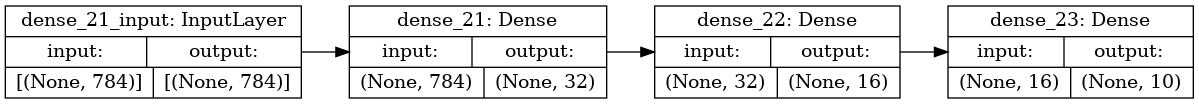

In [55]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

#### Compile and Train
Now we can compile and train the model. We'll train for 5 epochs.

In [56]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train, y_train, epochs=10, verbose=1, validation_data=(x_valid, y_valid), batch_size=128
)

Epoch 1/10
469/469 [==============================] - 1s 877us/step - loss: 0.8638 - accuracy: 0.7545 - val_loss: 0.2641 - val_accuracy: 0.9225
Epoch 2/10
469/469 [==============================] - 0s 701us/step - loss: 0.2569 - accuracy: 0.9266 - val_loss: 0.2071 - val_accuracy: 0.9395
Epoch 3/10
469/469 [==============================] - 0s 700us/step - loss: 0.2067 - accuracy: 0.9403 - val_loss: 0.1799 - val_accuracy: 0.9455
Epoch 4/10
469/469 [==============================] - 0s 679us/step - loss: 0.1732 - accuracy: 0.9507 - val_loss: 0.1654 - val_accuracy: 0.9482
Epoch 5/10
469/469 [==============================] - 0s 670us/step - loss: 0.1532 - accuracy: 0.9552 - val_loss: 0.1511 - val_accuracy: 0.9527
Epoch 6/10
469/469 [==============================] - 0s 662us/step - loss: 0.1359 - accuracy: 0.9605 - val_loss: 0.1520 - val_accuracy: 0.9537
Epoch 7/10
469/469 [==============================] - 0s 695us/step - loss: 0.1301 - accuracy: 0.9617 - val_loss: 0.1373 - val_accuracy:

In [57]:
import matplotlib.pyplot as plt

def plot_learning_and_loss_curves(history):
    """
    Given training history, plot the learning curves
    and the loss curves for both training and 
    validation datasets.
    """
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs = range(len(training_accuracy))

    plt.figure(constrained_layout=True, figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_accuracy, 'r', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_loss, 'r', label='Training Loss')
    plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)

    plt.show()

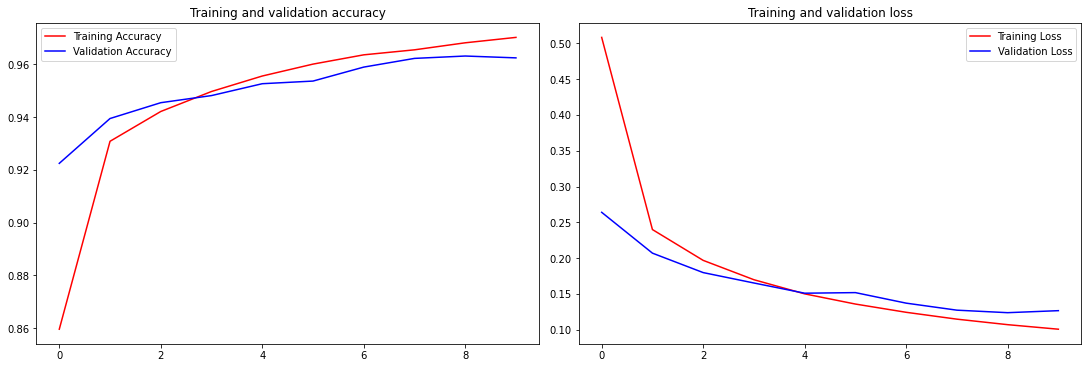

In [58]:
plot_learning_and_loss_curves(history)

In [63]:
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(784,)))
model.add(Dense(units = 10, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


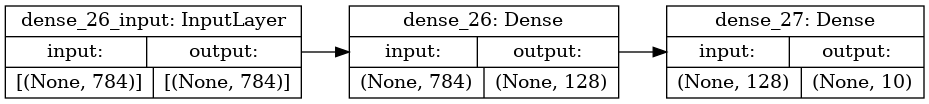

In [64]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [65]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x_train, y_train, epochs=10, verbose=1, validation_data=(x_valid, y_valid), batch_size=128
)

Epoch 1/10
469/469 [==============================] - 1s 1ms/step - loss: 0.5282 - accuracy: 0.8633 - val_loss: 0.1799 - val_accuracy: 0.9454
Epoch 2/10
469/469 [==============================] - 0s 1ms/step - loss: 0.1710 - accuracy: 0.9518 - val_loss: 0.1329 - val_accuracy: 0.9618
Epoch 3/10
469/469 [==============================] - 0s 1ms/step - loss: 0.1187 - accuracy: 0.9658 - val_loss: 0.1097 - val_accuracy: 0.9676
Epoch 4/10
469/469 [==============================] - 0s 1ms/step - loss: 0.0888 - accuracy: 0.9750 - val_loss: 0.0971 - val_accuracy: 0.9699
Epoch 5/10
469/469 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9790 - val_loss: 0.0835 - val_accuracy: 0.9745
Epoch 6/10
469/469 [==============================] - 0s 1ms/step - loss: 0.0570 - accuracy: 0.9837 - val_loss: 0.0776 - val_accuracy: 0.9764
Epoch 7/10
469/469 [==============================] - 0s 1ms/step - loss: 0.0501 - accuracy: 0.9858 - val_loss: 0.0738 - val_accuracy: 0.9781
Epoch 

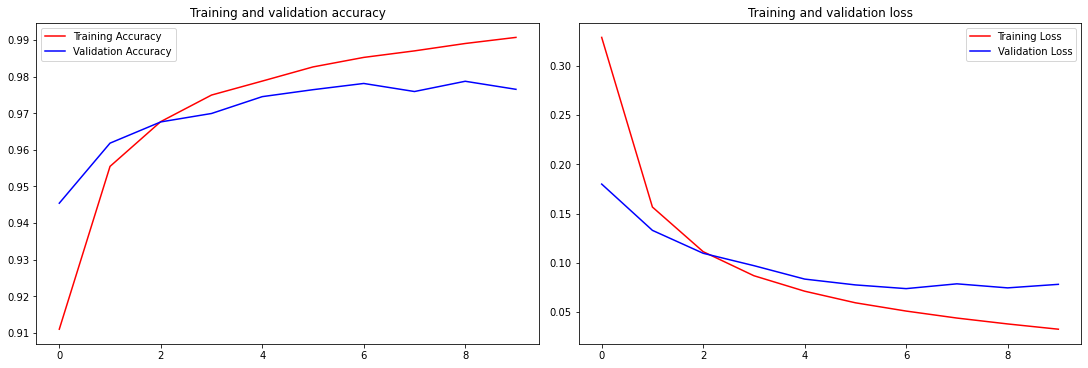

In [66]:
plot_learning_and_loss_curves(history)

### Inference
Now that we've trained a model, we can use it to run inference on new data. We can even export the model to load into another system for to run in production. Which raises the question, what exactly is our the model? What do we have now that we've finished training? 

https://blogs.nvidia.com/blog/2016/08/22/difference-deep-learning-training-inference-ai/